# m-pCMF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pCMF import mpCMF

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score

## Data set: Pollen et al, 2014
This data set contains 65 cells of four different types sequenced at low and high depth. We will use ZINBayes to visualize the cells in 2D with minimal technical bias.

We first visualize some properties of the data.

In [3]:
data_path = 'data/Pollen'
X = pd.read_csv(data_path + '/counts.csv').T
y = pd.read_csv(data_path + '/labels.csv')
b = pd.read_csv(data_path + '/batches.csv')


y = np.array(y)[:, 1]
y_names, y_id = np.unique(y, return_inverse=True)
celltypes = y_names

b = np.array(b)[:, 1]
b_names, b_id = np.unique(b, return_inverse=True)
coverage = b_names

b_onehot = OneHotEncoder().fit_transform(b_id.reshape(-1, 1)).toarray()

X = np.array(X)
gene_names = X[0, :]
X = np.array(X[1:, :], dtype=np.float32)
var_genes = np.var(X, axis=0)
X = X[:, np.argsort(var_genes)[-1000:]]

n_cells = X.shape[0]
n_genes = X.shape[1]
n_types = np.unique(y).size
n_batches = np.unique(b).size

print('Data shape:')
print('{} cells, {} genes\n'.format(X.shape[0], X.shape[1]))
print('{} cell types\n'.format(n_types))
print('{} experimental batches\n'.format(n_batches))
print('Percentage of zeros in the data set:')
print('{:.2f}%'.format(np.count_nonzero(X==0) / X.size * 100))

Data shape:
130 cells, 1000 genes

4 cell types

2 experimental batches

Percentage of zeros in the data set:
32.84%


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
labels = y_id
clusters = y

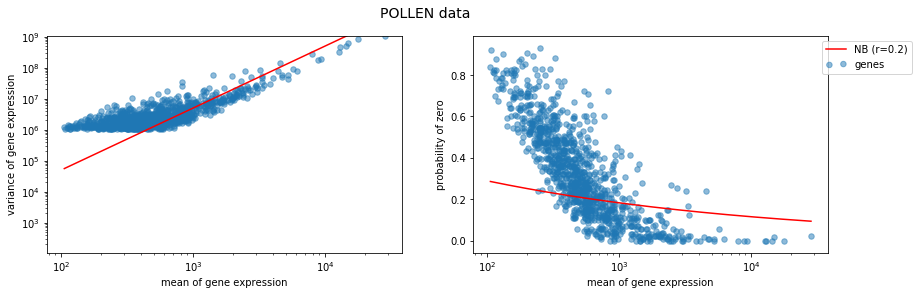

In [5]:
n_cells = X.shape[0]
n_genes = X.shape[1]

genecounts_mean = np.mean(X, axis=0)
genecounts_var = np.var(X, axis=0)

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
r_ = .2

s = 30
alpha = 0.5

fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
plt.xscale('log')
plt.yscale('log')
plt.scatter(genecounts_mean, genecounts_var, s=s, alpha=alpha)
# plt.plot(x, x, color='red')
plt.plot(x, x + 1/r_ * x**2, color='red')
plt.xlabel('mean of gene expression')
plt.ylabel('variance of gene expression')
plt.ylim(min(genecounts_mean.min(), genecounts_var.min()), max(genecounts_mean.max(), genecounts_var.max()))

# Dropout probability of each gene: number of cells with zero count of that gene / total number of cells
dropout_prob = np.sum(X==0, axis=0) / n_cells

x = np.linspace(genecounts_mean.min(), genecounts_mean.max(), num=100000)
poi_zeros = np.exp(-x)
nb_zeros = (r_/(x + r_))**r_

ax = plt.subplot(1, 2, 2)
plt.xscale('log')
plt.scatter(genecounts_mean, dropout_prob, label='genes', s=s, alpha=alpha)
# plt.plot(x, poi_zeros, color='red', label='Poisson')
plt.plot(x, nb_zeros, color='red', label='NB (r={})'.format(r_))
plt.xlabel('mean of gene expression')
plt.ylabel('probability of zero')
plt.legend(scatterpoints=2, frameon=True, bbox_to_anchor=[1.25, 1.0])

plt.suptitle('POLLEN data', fontsize=14)
# plt.savefig('PBMC_Poisson.pdf', dpi=300, bbox_inches='tight')
plt.show()


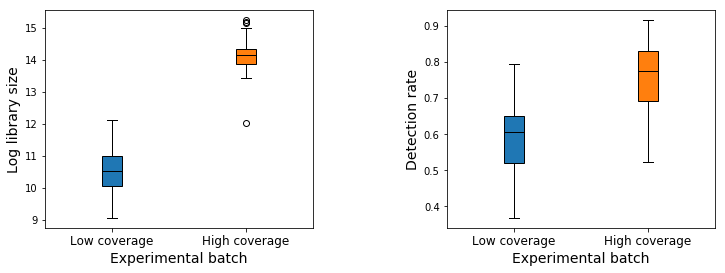

In [6]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)

bplot = plt.boxplot([np.log(np.sum(X[b_id==1], axis=1)), np.log(np.sum(X[b_id==0], axis=1))], patch_artist=True, )
ax.set_xticklabels(['Low coverage', 'High coverage'], fontsize=12)
plt.ylabel('Log library size', fontsize=14)
plt.xlabel('Experimental batch', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')
    
    
ax = plt.subplot(1, 2, 2)
bplot = plt.boxplot([np.sum(X[b_id==1] !=0, axis=1)/X.shape[1], np.sum(X[b_id==0]!=0, axis=1)/X.shape[1]], patch_artist=True)
ax.set_xticklabels(['Low coverage', 'High coverage'], fontsize=12)
plt.ylabel('Detection rate', fontsize=14)
plt.xlabel('Experimental batch', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

fig.subplots_adjust(wspace=.5)

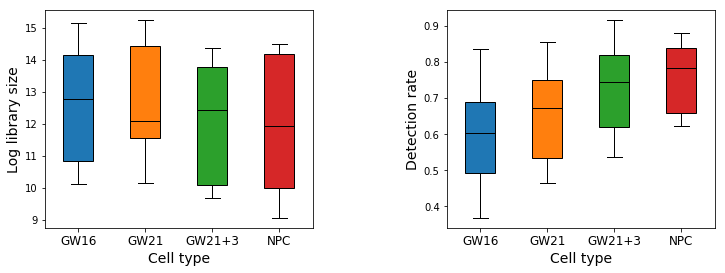

In [7]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 2, 1)
bplot = plt.boxplot([np.log(np.sum(X[labels==0], axis=1)), np.log(np.sum(X[labels==1], axis=1)), 
             np.log(np.sum(X[labels==2], axis=1)), np.log(np.sum(X[labels==3], axis=1))], patch_artist=True)
ax.set_xticklabels([y_names[0], y_names[1], y_names[2], y_names[3]], fontsize=12)
plt.ylabel('Log library size', fontsize=14)
plt.xlabel('Cell type', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

ax = plt.subplot(1, 2, 2)
bplot = plt.boxplot([np.sum(X[labels==0] !=0, axis=1)/X.shape[1], 
             np.sum(X[labels==1] !=0, axis=1)/X.shape[1], np.sum(X[labels==2] !=0, axis=1)/X.shape[1], 
             np.sum(X[labels==3]!=0, axis=1)/X.shape[1]], patch_artist=True)
ax.set_xticklabels([y_names[0], y_names[1], y_names[2], y_names[3]], fontsize=12)
plt.ylabel('Detection rate', fontsize=14)
plt.xlabel('Cell type', fontsize=14)
for patch, color in zip(bplot['boxes'], plt.rcParams['axes.prop_cycle'].by_key()['color']):
    patch.set_facecolor(color)
for element in ['fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color='black')

fig.subplots_adjust(wspace=.5)

## Run m-pCMF without scalings, batch correction and zeros
Batch effects will dominate;

Within each batch, red and green differentiate but blue and orange overlap with everything.

Notice the scale of each latent component. It is very large because it is also modelling for size factors.

In [13]:
mpcmf = mpCMF(X, c_train=labels, n_components=2, b_train=b_onehot, scalings=False, sparsity=False, 
                  zero_inflation=False, batch_correction=False, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=False, do_corr=False)

m-pCMF:
Running m-pCMF...
Iteration 55/1000. ELBO: -537892.2065741. Improvement: 0.0000443. Elapsed: 0h0m2s
Convergence criterion reached.

Done.


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [14]:
mpcmf.asw

-0.1039136241902309

In [15]:
mpcmf.batch_asw

0.4734449771790069

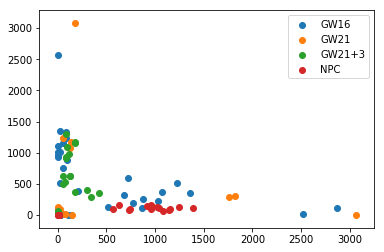

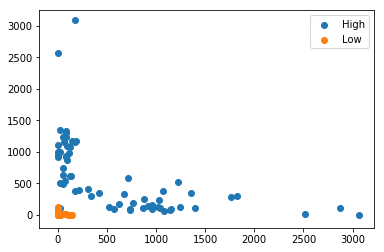

In [16]:
for c in range(len(y_names)):
    plt.scatter(mpcmf.est_U[labels==c, 0], mpcmf.est_U[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(mpcmf.est_U[b_id==c, 0], mpcmf.est_U[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run m-pCMF with scalings, without zeros and batch correction
The scale of the z space is very small because it is directly related to the size factors instead of being normalized before scaling.

In [22]:
mpcmf = mpCMF(X, c_train=labels, n_components=2, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=False, batch_correction=False, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=False)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=False, do_corr=False)

m-pCMF:
Considering cell-specific scalings.
Running m-pCMF...
Iteration 61/1000. ELBO: -535260.7843742. Improvement: 0.0000452. Elapsed: 0h0m3s
Convergence criterion reached.

Done.


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [23]:
mpcmf.asw

-0.10481577613572121

In [24]:
mpcmf.batch_asw

0.46899708101675114

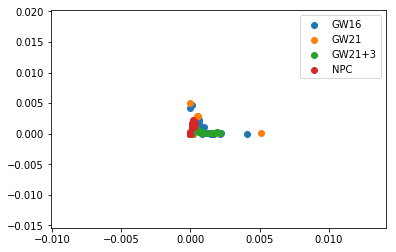

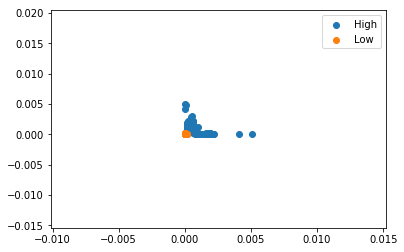

In [25]:
for c in range(len(y_names)):
    plt.scatter(mpcmf.est_U[labels==c, 0], mpcmf.est_U[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(mpcmf.est_U[b_id==c, 0], mpcmf.est_U[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run m-pCMF without batch annotations and scalings, with zero-inflation
Red overlaps with blue.

In [26]:
mpcmf = mpCMF(X, c_train=labels, n_components=2, b_train=b_onehot, scalings=False, sparsity=False, 
                  zero_inflation=True, batch_correction=False, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=False)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=False, do_corr=False)

m-pCMF:
Considering zero-inflated counts.
Running m-pCMF...
Iteration 59/1000. ELBO: -428700.4986377. Improvement: 0.0000481. Elapsed: 0h0m4s
Convergence criterion reached.

Done.


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [27]:
mpcmf.asw

-0.1239429680324764

In [28]:
mpcmf.batch_asw

0.4623820560482245

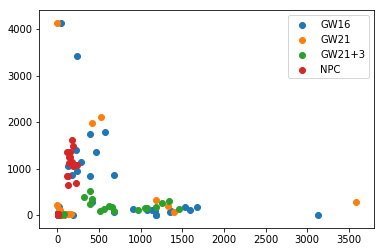

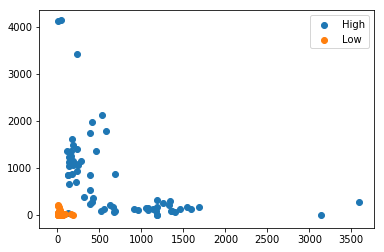

In [29]:
for c in range(len(y_names)):
    plt.scatter(mpcmf.est_U[labels==c, 0], mpcmf.est_U[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(mpcmf.est_U[b_id==c, 0], mpcmf.est_U[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run m-pCMF without batch annotations, with scalings and zero-inflation
Not much difference in using zero-inflation once scalings are applied.

In [30]:
mpcmf = mpCMF(X, c_train=labels, n_components=2, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=True, batch_correction=False, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=False)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.00005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=False, do_corr=False)

m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Running m-pCMF...
Iteration 42/1000. ELBO: -424223.0411322. Improvement: 0.0000458. Elapsed: 0h0m3s
Convergence criterion reached.

Done.


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [31]:
mpcmf.asw

-0.0999271289126059

In [32]:
mpcmf.batch_asw

0.494724270570648

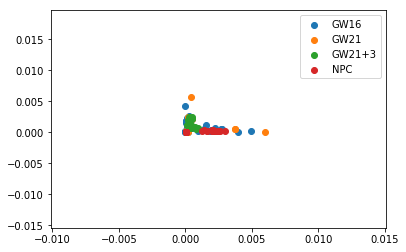

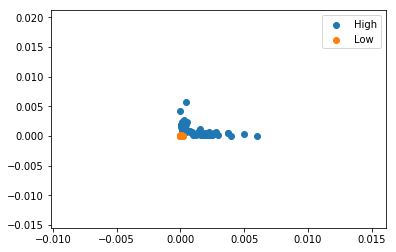

In [33]:
for c in range(len(y_names)):
    plt.scatter(mpcmf.est_U[labels==c, 0], mpcmf.est_U[labels==c, 1], label=y_names[c])
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(mpcmf.est_U[b_id==c, 0], mpcmf.est_U[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

## Run m-pCMF with batch annotations, scalings and zero-inflation
With not forcing a NB, the zero-inflation captures basically all the zeros, because the Poisson does not expect the huge over-dispersion in the data that may naturally lead to more zeros.

However, forcing a NB results in not modelling the size factors which results in not being able to separate the batches. For very large library sizes, using the NB is not an option.

In [64]:
mpcmf = mpCMF(X, c_train=labels, n_components=2, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=True, batch_correction=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=False, disp=.2)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.000005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=False, do_corr=False)

m-pCMF:
Considering cell-specific scalings.
Considering zero-inflated counts.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 262/1000. ELBO: -412058.3437159. Improvement: 0.0000050. Elapsed: 0h0m24s
Convergence criterion reached.

Done.


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [65]:
mpcmf.asw

0.10531538152542615

In [66]:
mpcmf.batch_asw

0.018331859629403726

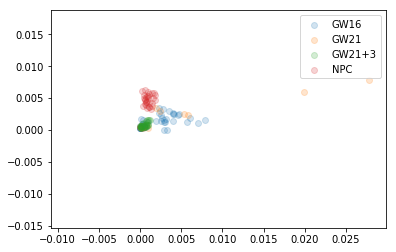

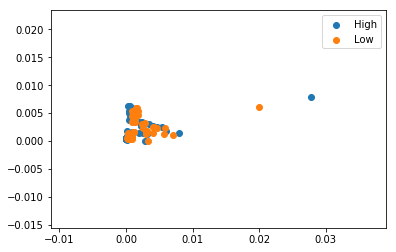

In [79]:
for c in range(0,len(y_names)):
    plt.scatter(mpcmf.est_U[labels==c, 0], mpcmf.est_U[labels==c, 1], label=y_names[c], alpha=0.2)
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(mpcmf.est_U[b_id==c, 0], mpcmf.est_U[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

(array([83., 20.,  8., 14.,  4.,  0.,  0.,  0.,  0.,  1.]),
 array([8.25221802e+00, 1.25601529e+03, 2.50377836e+03, 3.75154143e+03,
        4.99930450e+03, 6.24706757e+03, 7.49483064e+03, 8.74259371e+03,
        9.99035678e+03, 1.12381198e+04, 1.24858829e+04]),
 <a list of 10 Patch objects>)

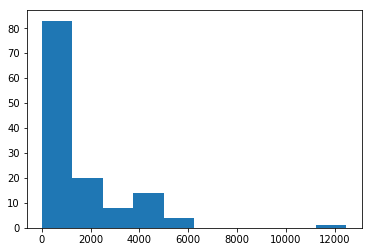

In [80]:
plt.hist(mpcmf.est_L)

(array([4.2435e+04, 1.2400e+02, 6.2000e+01, 2.5000e+01, 1.8000e+01,
        1.9000e+01, 8.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.94065646e-324, 8.41904101e-002, 1.68380820e-001, 2.52571230e-001,
        3.36761641e-001, 4.20952051e-001, 5.05142461e-001, 5.89332871e-001,
        6.73523281e-001, 7.57713691e-001, 8.41904101e-001]),
 <a list of 10 Patch objects>)

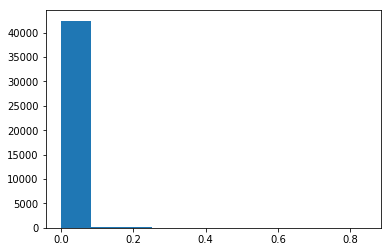

In [81]:
plt.hist(mpcmf.inf.p_D[X==0])

## Run m-pCMF with batch annotations, scalings and zero-inflation and NB
Forcing a NB results in not modelling the size factors which results in not being able to separate the batches. For very large library sizes, using the NB is not an option.

In [94]:
mpcmf = mpCMF(X, c_train=labels, n_components=2, b_train=b_onehot, scalings=True, sparsity=False, 
                  zero_inflation=True, batch_correction=True, empirical_bayes=False, do_imp=False, name="m-pCMF", minibatch_size=None, 
                  nb=True, disp=10)
mpcmf.run(max_iter=1000, max_time=60*30, do_silh=True, do_holl=False, do_dll=False, tol=0.000005,
          do_tsne=False, do_batch=True, calc_test=False, verbose=True, calc_silh=False, do_corr=False)

m-pCMF:
Considering cell-specific scalings.
Considering NB structure.
Considering zero-inflated counts.
Considering 2 experimental batches.
Running m-pCMF...
Iteration 351/1000. ELBO: -415080.1528281. Improvement: 0.0000050. Elapsed: 0h0m31s
Convergence criterion reached.

Done.


/home/pedro/IST/Thesis/pCMF/venv/lib/python3.5/site-packages/scikit_learn-0.20.0-py3.5-linux-x86_64.egg/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [95]:
mpcmf.asw

-0.1908491609287207

In [96]:
mpcmf.batch_asw

0.32399030166168036

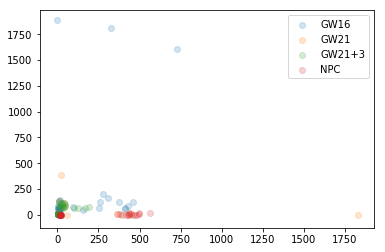

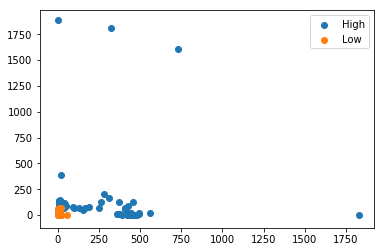

In [97]:
for c in range(0,len(y_names)):
    plt.scatter(mpcmf.est_U[labels==c, 0], mpcmf.est_U[labels==c, 1], label=y_names[c], alpha=0.2)
plt.legend()
plt.show()

for c in range(len(b_names)):
    plt.scatter(mpcmf.est_U[b_id==c, 0], mpcmf.est_U[b_id==c, 1], label=b_names[c])
plt.legend()
plt.show()

(array([21., 24., 34.,  8., 13., 16.,  8.,  3.,  0.,  3.]),
 array([ 0.61089202,  1.96230855,  3.31372508,  4.66514161,  6.01655813,
         7.36797466,  8.71939119, 10.07080772, 11.42222425, 12.77364078,
        14.12505731]),
 <a list of 10 Patch objects>)

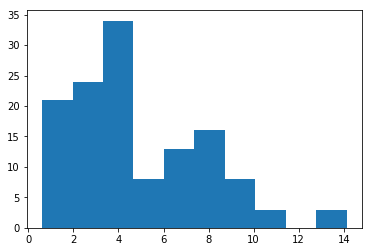

In [98]:
plt.hist(mpcmf.est_L)

(array([4.2166e+04, 2.3100e+02, 1.2600e+02, 8.1000e+01, 4.7000e+01,
        2.0000e+01, 7.0000e+00, 0.0000e+00, 3.0000e+00, 1.5000e+01]),
 array([4.94065646e-324, 7.40298102e-002, 1.48059620e-001, 2.22089431e-001,
        2.96119241e-001, 3.70149051e-001, 4.44178861e-001, 5.18208672e-001,
        5.92238482e-001, 6.66268292e-001, 7.40298102e-001]),
 <a list of 10 Patch objects>)

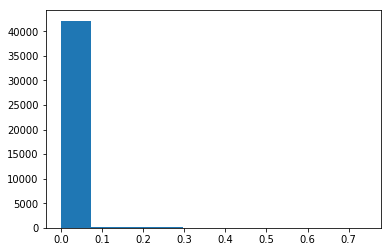

In [99]:
plt.hist(mpcmf.inf.p_D[X==0])